In [1]:
# Базовые библиоткеи
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
# Стандартные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D,  GlobalMaxPooling1D
# Рекурентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN,  Bidirectional, concatenate
# Алгоритмы обучения\оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

# Инструменты предобработки текста
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

### Загрузка данных<br>
Перед началом работы, данные неоюходимо импортировать, сделать это можно при помощи стандартной библиотеки os, а для работы с данными можно использовать pandas

In [2]:
path = 'база болезней/'
# При помощи простого выражения (list comprehension) можно создать список из всех болезней
diseases_names = [x.split('.')[0] for x in os.listdir(path)]
diseases_names

['Аппендицит',
 'Гастрит',
 'Гепатит',
 'Дуоденит',
 'Колит',
 'Панкреатит',
 'Холицестит',
 'Эзофагит',
 'Энтерит',
 'Язва']

In [3]:
# Создание набора данных (DataFrmae)
df = pd.DataFrame(columns=['disease_name', 'disease_description'])
# При помощи цикла проходимся по списку
for disease in diseases_names:
    # Открываем каждый файл для чтения
    with open(path+disease+'.txt', mode='r', encoding='utf-8-sig') as f:
        current_disease = f.read()
        # Добавление названия болещни и ее описания в набор данных
        df = pd.concat([df, pd.DataFrame({'disease_name':[disease], 'disease_description':[current_disease]})], ignore_index=True)

In [4]:
# Удаление лишних символов переноса строки
df['disease_description'] = df['disease_description'].apply(lambda x: x.replace('\n', ' '))
df

,disease_name,disease_description
0,Аппендицит,Резкая боль в животе Повышение температуры Нап...
1,Гастрит,ГАСТРИТ СИМПТОМЫ диспепсии (тяжесть и чувство...
2,Гепатит,Желтуха начало гепатита напоминает грипп: повы...
3,Дуоденит,"боль в эпигастральной области, тошнота, рвота,..."
4,Колит,"постоянные позывы на дефекацию, урчание, вздут..."
5,Панкреатит,Боль при панкреатите обычно очень интенсивн...
6,Холицестит,"тупая, ноющая боль в области правого подреберь..."
7,Эзофагит,затруднения и болезненные ощущения при глотани...
8,Энтерит,внезапныые боли (преимущественно в середине жи...
9,Язва,"боль, часто локализованная в эпигастрии и умен..."


In [5]:
all_diseases_description = ' '.join(df['disease_description'].values)

### Обучение токенизатора

In [6]:
max_words_count = 1800
tokenizer = Tokenizer(num_words=max_words_count,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token='unknown'
)

tokenizer.fit_on_texts([all_diseases_description])
items = list(tokenizer.word_index.items())
print(items[:100])
print("Размер словаря", len(items)) # Длина словаря

[('unknown', 1), ('в', 2), ('и', 3), ('боль', 4), ('тошнота', 5), ('или', 6), ('рвота', 7), ('боли', 8), ('живота', 9), ('при', 10), ('животе', 11), ('после', 12), ('области', 13), ('отрыжка', 14), ('с', 15), ('слабость', 16), ('аппетита', 17), ('во', 18), ('тела', 19), ('изжога', 20), ('вздутие', 21), ('может', 22), ('снижение', 23), ('пищи', 24), ('повышение', 25), ('температуры', 26), ('рту', 27), ('еды', 28), ('диарея', 29), ('на', 30), ('иногда', 31), ('до', 32), ('к', 33), ('метеоризм', 34), ('температура', 35), ('подреберье', 36), ('верхней', 37), ('части', 38), ('не', 39), ('правом', 40), ('стул', 41), ('потеря', 42), ('чувство', 43), ('общая', 44), ('эпигастральной', 45), ('желудка', 46), ('урчание', 47), ('–', 48), ('ощущение', 49), ('отсутствие', 50), ('ощущения', 51), ('понос', 52), ('нарушение', 53), ('позывы', 54), ('тяжести', 55), ('которая', 56), ('запор', 57), ('время', 58), ('приема', 59), ('кожи', 60), ('могут', 61), ('появление', 62), ('повышенная', 63), ('эпигастри

In [7]:
tokenizer.word_index['язв']

878

### Преобразование данных

In [8]:
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
    xSample = [] # Объявляем переменную для векторов
    wordsLen = len(wordIndexes) # Считаем количество слов
    index = 0 # Задаем начальный индекс 

    while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
        xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
        index += step # Смещаеммся вперёд на step
    
    return xSample

In [9]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

    # Для каждого из 6 классов
    # Создаём обучающую/проверочную выборку из индексов
    nClasses = len(wordIndexes) # Задаем количество классов выборки
    classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
    for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
        classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

    # Формируем один общий xSamples
    xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
    ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

    for t in range(nClasses): # В диапазоне кол-ва классов(6)
        xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
        for i in range(len(xT)): # И каждое его окно
            xSamples.append(xT[i]) # Добавляем в общий список выборки
            ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

    xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
    ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
    return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

In [10]:
#Задаём базовые параметры
xLen = 50 #Длина отрезка текста, по которой анализируем, в словах
step = 5 #Шаг разбиения исходного текста на обучающие векторы

In [11]:
df['sequences_description'] = df['disease_description'].apply(lambda x: tokenizer.texts_to_sequences([x]))

In [12]:
df

,disease_name,disease_description,sequences_description
0,Аппендицит,Резкая боль в животе Повышение температуры Нап...,"[[99, 4, 2, 11, 25, 26, 879, 211, 5, 100, 4, 2..."
1,Гастрит,ГАСТРИТ СИМПТОМЫ диспепсии (тяжесть и чувство...,"[[592, 130, 334, 66, 3, 43, 101, 593, 2, 160, ..."
2,Гепатит,Желтуха начало гепатита напоминает грипп: повы...,"[[133, 1008, 1009, 1010, 1011, 25, 26, 19, 97,..."
3,Дуоденит,"боль в эпигастральной области, тошнота, рвота,...","[[4, 2, 45, 13, 5, 7, 44, 16, 86, 10, 173, 2, ..."
4,Колит,"постоянные позывы на дефекацию, урчание, вздут...","[[295, 54, 30, 202, 47, 21, 9, 1149, 52, 31, 1..."
5,Панкреатит,Боль при панкреатите обычно очень интенсивн...,"[[4, 10, 308, 91, 116, 1304, 85, 83, 425, 331,..."
6,Холицестит,"тупая, ноющая боль в области правого подреберь...","[[153, 112, 4, 2, 13, 313, 393, 1615, 106, 6, ..."
7,Эзофагит,затруднения и болезненные ощущения при глотани...,"[[544, 3, 178, 51, 10, 208, 20, 8, 18, 27, 51,..."
8,Энтерит,внезапныые боли (преимущественно в середине жи...,"[[1, 8, 414, 2, 858, 9, 7, 52, 25, 26, 130, 39..."
9,Язва,"боль, часто локализованная в эпигастрии и умен...","[[4, 72, 699, 2, 64, 3, 1, 12, 28, 6, 553, 4, ..."


### Проверка распределения

Теперь, что бы убедится, что все коныертировалось верно, проверю матрицу

In [13]:
'язв' in tokenizer.sequences_to_texts(df['sequences_description'][9])[0].split(' ')

True

In [14]:
maxlen = 800
#Формируем матрицу индексов по принципу Bag of Words
xAll =  [x[0] for x in df['sequences_description'].values]#Каждое слово из текста нашло свой индекс в векторе длиной maxWordsCount и отметилось в нем единичкой 
xAll = pad_sequences(xAll, maxlen=maxlen, padding='pre', truncating='pre') #Преобразуем входные векторы
print(xAll.shape)  #Посмотрим на форму текстов

(10, 800)


In [15]:
#Формируем обучающую выборку
xTrain, yTrain = createSetsMultiClasses(xAll, xLen, step) #извлекаем обучающую выборку
print(xTrain.shape)
print(yTrain.shape)

(1510, 50)
(1510, 10)


In [26]:
maxlen

800

### Создание сети

Dense - Стандартная сеть
LSTM - Рекурентная
Conv1D - Сверточная сетка


In [35]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model

input_layer = Input(shape = (50, ))

# Левая ветка
left = Embedding(max_words_count, 16, input_length=xLen) (input_layer)
left = SpatialDropout1D(0.4) (left)
left = BatchNormalization() (left)

left = LSTM(12, return_sequences=True) (left)
left = Bidirectional(LSTM(6, return_sequences=True)) (left)

left = Conv1D(12, 4, activation='relu') (left)
left = MaxPooling1D(2) (left)
left = BatchNormalization() (left)
left = Conv1D(6, 4, activation='relu') (left)
left = MaxPooling1D(2) (left)
left = BatchNormalization() (left)
left = Dropout(0.2) (left)

left = GlobalMaxPooling1D() (left)
left = Dense(100, activation='relu') (left)



# Правая ветка
right = Embedding(max_words_count, 16, input_length=xLen) (input_layer)
right = SpatialDropout1D(0.4) (right)
right = BatchNormalization() (right)

right = Conv1D(6, 4, activation='relu') (right)
right = MaxPooling1D(2) (right)
right = BatchNormalization() (right)
right = Dropout(0.2) (right)

right = LSTM(12, return_sequences=True) (right)
right = Dense(100, activation='relu') (right)
right = Flatten() (right)

# Объединяем скрытые слои в один
merged = concatenate([left, right])
output = Flatten() (merged)
output = Dense(yTrain.shape[1], activation='softmax')(merged)

# Создание модели
model = Model(inputs=input_layer, outputs=output)

In [36]:
# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [39]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=25,
                    batch_size=32,
                    validation_split = 0.2)

Epoch 1/25
38/38 [==============================] - 2s 57ms/step - loss: 0.2504 - accuracy: 0.9238 - val_loss: 8.0117 - val_accuracy: 0.0000e+00
Epoch 2/25
38/38 [==============================] - 2s 48ms/step - loss: 0.2024 - accuracy: 0.9214 - val_loss: 10.1384 - val_accuracy: 0.0000e+00
Epoch 3/25
38/38 [==============================] - 2s 50ms/step - loss: 0.1615 - accuracy: 0.9346 - val_loss: 12.6632 - val_accuracy: 0.0000e+00
Epoch 4/25
38/38 [==============================] - 2s 51ms/step - loss: 0.1489 - accuracy: 0.9487 - val_loss: 13.8039 - val_accuracy: 0.0000e+00
Epoch 5/25
38/38 [==============================] - 2s 50ms/step - loss: 0.1367 - accuracy: 0.9429 - val_loss: 14.9377 - val_accuracy: 0.0000e+00
Epoch 6/25
38/38 [==============================] - 2s 54ms/step - loss: 0.1203 - accuracy: 0.9536 - val_loss: 15.2235 - val_accuracy: 0.0000e+00
Epoch 7/25
38/38 [==============================] - 2s 51ms/step - loss: 0.1283 - accuracy: 0.9437 - val_loss: 15.2572 - val_

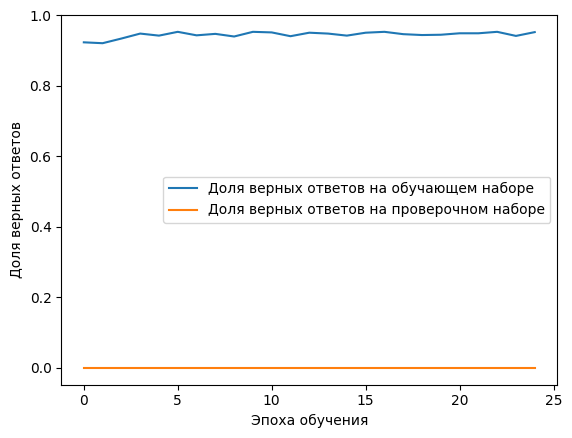

In [40]:
# Строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()